##**Setting up Graph Tool in Colab**


##**Importing the Network and Required Libraries**

In [10]:
# U.S. Patent Citation Network Analysis using graph-tool
import graph_tool.all as gt
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time

In [11]:
g = gt.collection.ns["us_patents"]

##**Spring Layout Visualization**


In [12]:
# Parameters
num_iterations = 1000  # Total number of iterations
batch_size = 10  # Number of iterations per update
num_batches = num_iterations // batch_size

# Create a progress bar
pbar = tqdm(total=num_batches, desc="Generating layout", dynamic_ncols=True)

# Initialize layout
pos = gt.random_layout(g)

# Incrementally compute the layout in batches
start_time = time.time()
for _ in range(num_batches):
    pos = gt.sfdp_layout(g, pos=pos, epsilon=1e-2, C=1.0, max_iter=batch_size)
    
    # Update progress bar and estimate time remaining
    elapsed = time.time() - start_time
    avg_time_per_batch = elapsed / (_ + 1)
    time_remaining = avg_time_per_batch * (num_batches - _ - 1)
    pbar.set_postfix({'time remaining': f"{time_remaining:.2f} seconds"})
    pbar.update(1)
pbar.close()

# Graph with more transparent edges and slightly smaller vertices
edge_pen_width = gt.prop_to_size(gt.betweenness(g)[1], mi=0.1, ma=1.5)
gt.graph_draw(g, pos, output_size=(1000, 1000), vertex_size=0.5, edge_pen_width=edge_pen_width, edge_color=[0.7,0.7,0.7,0.2], output="spring_layout.png")

Generating layout:   0%|          | 0/100 [00:00<?, ?it/s]

##**Descriptive Measures**

Number of Patents (Nodes) and Citations (Edges)

In [5]:
num_patents = g.num_vertices()
num_citations = g.num_edges()
print(f"Number of Patents (Nodes): {num_patents}")
print(f"Number of Citations (Edges): {num_citations}")

Visualization of Patents(Nodes) and Citations (Edges)

In [ ]:
labels = ['Patents', 'Citations']
values = [num_patents, num_citations]

plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=['blue', 'green'])
plt.title("Number of Patents vs. Citations")
plt.ylabel("Count")
for i, v in enumerate(values):
    plt.text(i, v + 50, str(v), ha='center', va='bottom', fontweight='bold')  # Displaying the actual count above the bars
plt.show()

Degree Distribution

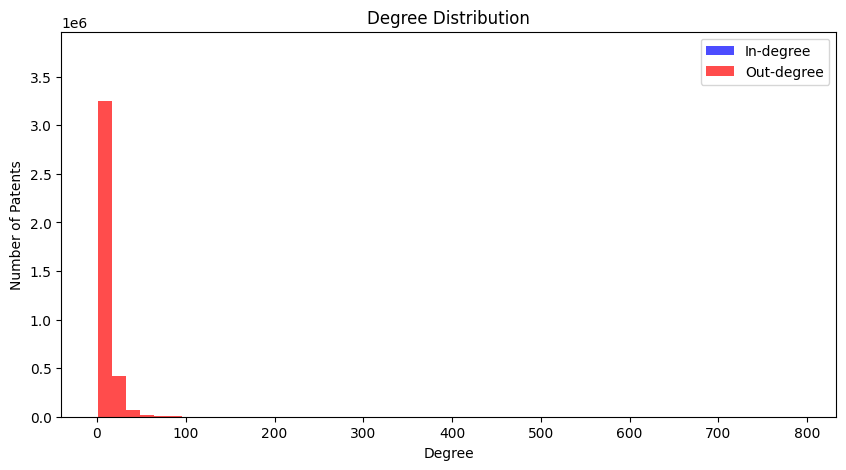

In [6]:
in_degrees = g.degree_property_map("in").a
out_degrees = g.degree_property_map("out").a

plt.figure(figsize=(10,5))
plt.hist(in_degrees, bins=50, color='blue', alpha=0.7, label="In-degree")
plt.hist(out_degrees, bins=50, color='red', alpha=0.7, label="Out-degree")
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Number of Patents")
plt.legend()
plt.show()

Identifing Patents Hubs

In [ ]:
vertex_betweenness = gt.betweenness(g)[0]
threshold = np.percentile(vertex_betweenness.a, 95)
key_patents = [(g.vertex(v), centrality) for v, centrality in enumerate(vertex_betweenness.a) if centrality > threshold]

##**Shortest Paths**

Highest Degree

In [ ]:
# Identify patent with highest in-degree (most citations received)
most_cited_vertex = np.argmax(in_degrees)

Highest Betweenness Centrality

In [ ]:
# Identify patent with highest betweenness centrality
most_central_vertex = np.argmax(vertex_betweenness.a)

Shortest Path

In [ ]:
shortest_path_vertices = gt.shortest_path(g, g.vertex(most_cited_vertex), g.vertex(most_central_vertex))[0]

##**Percolation Threshold**

In [ ]:
# Percolation analysis
comp, hist = gt.vertex_percolation(g)
threshold = np.argmax(hist.a) / g.num_vertices()

# Plotting
plt.figure(figsize=(10,5))
plt.plot(hist.a / g.num_vertices(), label="Component Size", color="blue")
plt.axvline(x=threshold, color='red', linestyle='--', label=f"Threshold: {threshold:.2f}")
plt.title("Vertex Percolation in U.S. Patent Citation Network")
plt.xlabel("Fraction of Vertices Removed")
plt.ylabel("Normalized Component Size")
plt.legend()
plt.show()

##**K-core Decomposition**

In [ ]:
core_prop = gt.kcore_decomposition(g)
max_core = core_prop.a.max()

Histogram of Core Numbers

In [ ]:
# Histogram of core numbers
plt.figure(figsize=(10,5))
plt.hist(core_prop.a, bins=range(1, max_core + 2), align='left', rwidth=0.8, color='purple', alpha=0.7)
plt.title('Distribution of k-Core Numbers in U.S. Patent Citation Network')
plt.xlabel('Core Number')
plt.ylabel('Number of Vertices')
plt.xticks(list(range(1, max_core + 1)))
plt.show()

Visualization Highlighting the Cores

In [ ]:
# Visualize the graph highlighting the cores
color_by_core = core_prop.a / max_core  # normalize for coloring
gt.graph_draw(g, pos, vertex_fill_color=color_by_core, vertex_size=5, edge_pen_width=0.5, output_size=(1000, 1000), vcmap=plt.cm.plasma, output="kcore_decomposition.png")

## **Centrality Meausers**

In [ ]:
def plot_centrality_histograms(g):
    """Plots histograms for various centrality measures."""

    # Betweenness Centrality
    vertex_betweenness, _ = gt.betweenness(g)
    plt.figure(figsize=(15,4))
    plt.hist(vertex_betweenness.a, bins=50, color='skyblue', alpha=0.7)
    plt.title('Distribution of Betweenness Centrality')
    plt.xlabel('Betweenness Centrality')
    plt.ylabel('Number of Vertices')
    plt.show()

    # Eigenvector Centrality
    _, eigenvector_centrality = gt.eigenvector(g)
    plt.figure(figsize=(15,4))
    plt.hist(eigenvector_centrality.a, bins=50, color='salmon', alpha=0.7)
    plt.title('Distribution of Eigenvector Centrality')
    plt.xlabel('Eigenvector Centrality')
    plt.ylabel('Number of Vertices')
    plt.show()

    # Closeness Centrality
    closeness_centrality = gt.closeness(g)
    plt.figure(figsize=(15,4))
    plt.hist(closeness_centrality.a, bins=50, color='lightgreen', alpha=0.7)
    plt.title('Distribution of Closeness Centrality')
    plt.xlabel('Closeness Centrality')
    plt.ylabel('Number of Vertices')
    plt.show()

In [ ]:
plot_centrality_histograms(g)

##**Blockmodel**

In [ ]:
state = gt.minimize_blockmodel_dl(g)
community_map = state.get_blocks().a

In [ ]:
# Draw the graph with vertices colored by their block labels
color = state.get_blocks()
gt.graph_draw(g, pos, vertex_fill_color=color, output_size=(1000, 1000), vertex_size=1, output="communities.png")

In [ ]:
# Size Distribution of Communities
plt.figure(figsize=(10,5))
plt.hist(community_map, bins=np.max(community_map)+1, color='green', alpha=0.7)
plt.title("Community Size Distribution")
plt.xlabel("Community Label")
plt.ylabel("Number of Patents")
plt.show()

##**Nested Blockmodel**

In [ ]:
state = gt.minimize_nested_blockmodel_dl(g)

In [ ]:
def draw_nested_blockmodel(g, pos, block, colormaps, filenames):
    """Drawing the nested blockmodel using different colormaps."""

    color_by_block = block.a / max(block.a)
    for cmap, fname in zip(colormaps, filenames):
        gt.graph_draw(g, pos, vertex_fill_color=color_by_block, vertex_size=5, edge_pen_width=0.5, output_size=(1000, 1000), vcmap=cmap, output=fname)

# List of colormaps and corresponding filenames
colormaps = [plt.cm.jet, plt.cm.viridis, plt.cm.plasma, plt.cm.inferno]
filenames = ["nested_blockmodel_jet.png", "nested_blockmodel_viridis.png", "nested_blockmodel_plasma.png", "nested_blockmodel_inferno.png"]

# Call the function with the block data
block = state.get_bs()[0]
draw_nested_blockmodel(g, pos, block, colormaps, filenames)

### **Interpretation and Discussion**

---

